Suppose we wanted to compare cell tracking results from two seperate models. We can do this with CoMET!

Load in data

In [3]:
## Load in Data
import json
import pandas as pd
import pickle

path_to_files = "/share/D3/data/hweiner/CoMET_out/Test_Out"

with open(f"{path_to_files}/WRF_AnalysisVariables_tobac.json", "r") as file:
    WRF_analysis_data = json.load(file)

with open(f"{path_to_files}/WRF_AnalysisVariables_tobac.json", "r") as file:
    WRF_analysis_data_tobac = json.load(file)

WRF_tracks_tobac = pd.read_csv(f"{path_to_files}/WRF_Tracks_tobac.csv")
WRF_tracks_tams = pd.read_csv(f"{path_to_files}/WRF_Tracks_tams.csv")

with open(f"{path_to_files}/WRF_segmentation_2d_tobac.pickle", "rb") as data:
    WRF_segmentation_2d_tobac = pickle.load(data)
with open(f"{path_to_files}/WRF_segmentation_2d_tams.pickle", "rb") as data:
    WRF_segmentation_2d_tams = pickle.load(data)

We can now make the analysis plots

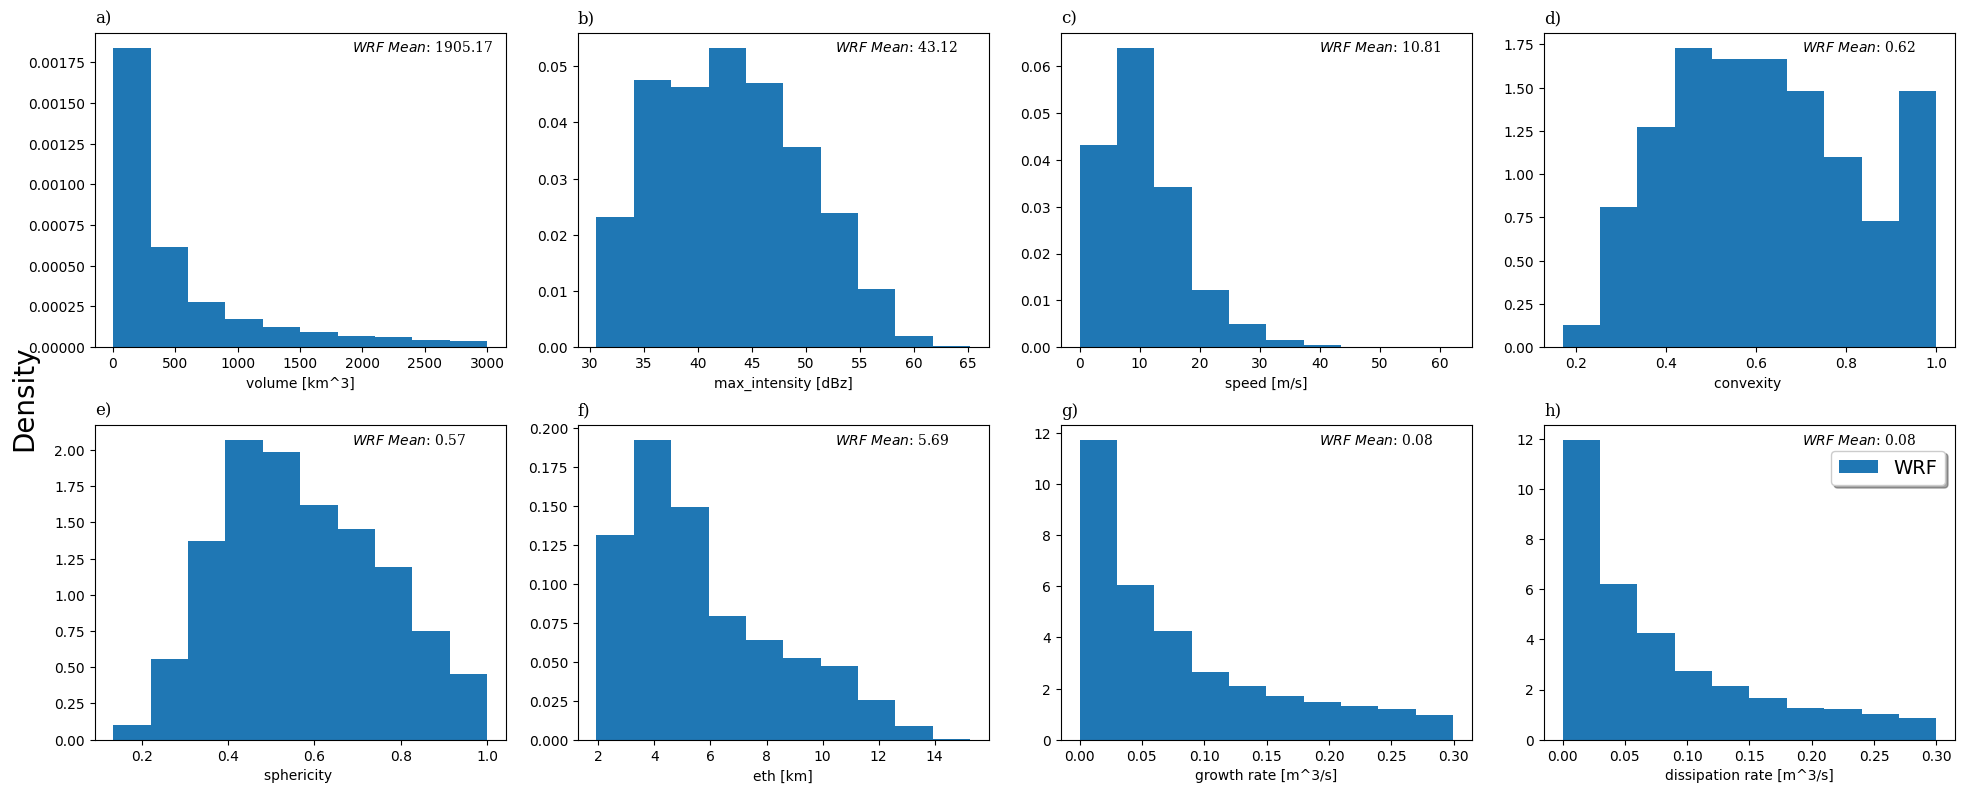

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the data
rows = 2
cols = 4

fig,ax = plt.subplots(rows, cols, figsize=[20, 8])
x_font_size = 14
fig.supylabel('Density', fontsize=20)

# define the list of variables and their units that you want to plot
    # note, cell growth can be broken into cell growth and dissipation, so plot it last
analysis_variable_list = ["volume", "max_intensity", "speed", "convexity", "sphericity", "eth", "cell_growth"]
limits = [3000, np.inf, np.inf, np.inf, np.inf, np.inf, 0.3] # manually adjust the limits of the plot to make them look nicer
unit_list = ["[km^3]", "[dBz]", "[m/s]", "", "", "[km]", "[m^3/s]", "[m^3/s]"]
mean_values = np.zeros(len(analysis_variable_list)+1)

for ind, analysis_variable, unit, limit in zip(np.arange(len(analysis_variable_list)), analysis_variable_list, unit_list, limits):

    col = ind % cols
    row = ind // cols

    if analysis_variable == "cell_growth":

        wrf_total_growth_info = np.array(WRF_analysis_data['wrf_tobac_cell_growth'])

        wrf_growth = wrf_total_growth_info[wrf_total_growth_info > 0]
        wrf_growth = wrf_growth[np.isfinite(wrf_growth)]
        wrf_growth = wrf_growth[wrf_growth < limit]

        ax[row, col].hist(wrf_growth, density=True, label="WRF")
        ax[row, col].set_xlabel(f"growth rate {unit}")

        wrf_dissipate = wrf_total_growth_info[wrf_total_growth_info < 0]
        wrf_dissipate = -wrf_dissipate[np.isfinite(wrf_dissipate)]
        wrf_dissipate = wrf_dissipate[wrf_dissipate < limit]


        ax[row, col+1].hist(wrf_dissipate, density=True, label="WRF")
        ax[row, col+1].set_xlabel(f"dissipation rate {unit}")

        mean_values[ind] = np.nanmean(wrf_growth)
        mean_values[ind+1] = np.nanmean(wrf_dissipate)
    
    else:

        wrf_plot = np.array(WRF_analysis_data[f"wrf_tobac_{analysis_variable}"])
        wrf_plot = wrf_plot[wrf_plot < limit]
        ax[row, col].hist(wrf_plot, density=True, label="WRF")
        ax[row, col].set_xlabel(f"{analysis_variable} {unit}")

        mean_values[ind] = np.nanmean(WRF_analysis_data[f"wrf_tobac_{analysis_variable}"])



the_alphabet = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']
axes_to_iterate = np.array(ax).reshape(-1)

# add the sublabels, mean statistics
for ind, let, axis in zip(range(len(the_alphabet)), the_alphabet, axes_to_iterate):

    mean_value_string = r"$\it{WRF \ Mean}$: " + f"{mean_values[ind]:.2f}\n"

    letter_xy = (-0.02, 1.1)

    axis.annotate(
        let,
        xy=letter_xy, xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize= 12, verticalalignment='top', fontfamily='serif',
        # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
        )

    xy = (0.61, 1)
    # if let == 'e)':
    #     xy = (0, 1)

    axis.annotate(
        mean_value_string,
        xy=xy, xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize= 10, verticalalignment='top', fontfamily='serif',    )

ax[1, 3].legend(bbox_to_anchor=(1, 0.95), fancybox=True, shadow=True, fontsize=14)

plt.tight_layout()
plt.show()

Plot cell propagation tracks

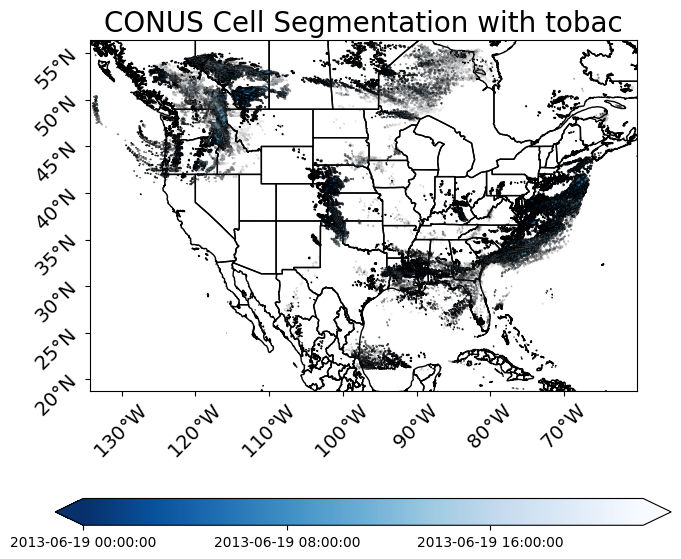

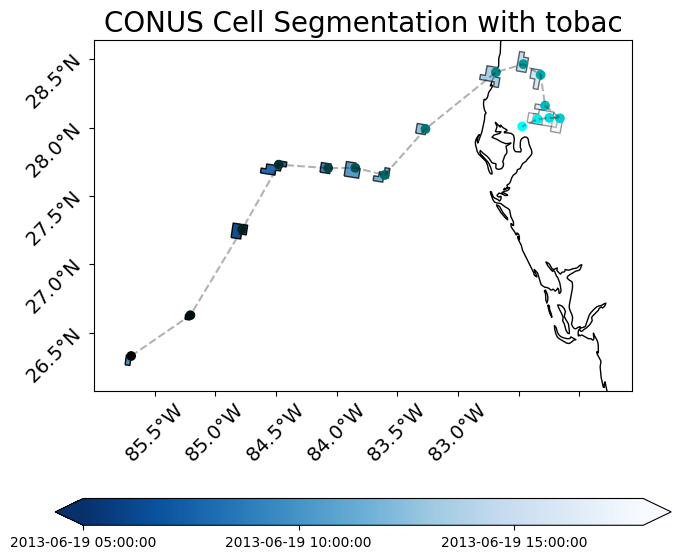

In [70]:
from shapely import geometry
import rasterio.features
import geopandas as gpd
import pandas as pd
import numpy as np
import datetime
import matplotlib.ticker as mticker
import xarray as xr
import matplotlib.pyplot as plt

def get_gdf_2d(segmentation, t = 0, cell = None):

    # Check to make sure the data is 2D
    if len(segmentation.Cell_Segmentation.shape) != 3:
        raise Exception("This function is only for two dimensional segmentation")
    
    # If there is a requested cell, get it
    if cell is None:
        cell_seg = segmentation.Cell_Segmentation[t].values
    else:
        cell_seg_full = segmentation.Cell_Segmentation[t].values
        cell_seg = -np.ones_like(cell_seg_full)
        cell_seg = np.where(cell_seg_full == cell, cell, cell_seg)

    # If there is no segmentation, return None
    if np.sum(cell_seg != -1) == 0:
        print(f'there are no cells at time {t}, returning None')
        return None

    lat_arr = segmentation.latitude.values
    lon_arr = segmentation.longitude.values

    # Make shapely polygons from numpy mask
    myShapes = rasterio.features.shapes(cell_seg, connectivity=8)
    x_y_coords_in_latlon = []
    values = []
    for shape in myShapes:
        x_y_coords_in_latlon.append(shape[0]["coordinates"][0])
        values.append(shape[1])

    polygons = []
    cell_list = []

    # Iterate through each of the cells in teh segmentation
    for ind, row in zip(values, x_y_coords_in_latlon):
        lat_list = []
        lon_list = []
        row_list = []
        skip = False
        for x, y in row:
            x_set = x - 1
            y_set = y - 1

            lat = lat_arr[int(y_set), int(x_set)]
            lon = lon_arr[int(y_set), int(x_set)]

            # If there are cells on the edge, get rid of them
            if ((x == 0. and y == 0.) or 
                x > lat_arr.shape[1] -50 or y > lat_arr.shape[0] - 30
            ):
                skip = True
            else:
                lat_list.append(lat)
                lon_list.append(lon)

                latlon_coord = (lat, lon)

                row_list.append(latlon_coord)

        if not(skip):
            cell_list.append(ind)
            polygons.append(geometry.Polygon(list(zip(lon_list, lat_list))))
    
    crs = "EPSG:4326"

    cell_df = pd.DataFrame({"cell_id" : cell_list})
    my_gdf2 = gpd.GeoDataFrame(cell_df, crs=crs, geometry=polygons)
    return my_gdf2

def plot_tracked_cells_2d(
        segmentation : xr.Dataset,
        tracks : gpd.GeoDataFrame,
        dt : int = 1,
        dataset_name : str = "WRF",
        tracker_name : str = "tobac",
        bounds : list[tuple, tuple] | None = None,
        cell: list | None = None,
        ):
    
    # Make sure the data is 2D
    if len(segmentation.Cell_Segmentation.shape) != 3:
        raise Exception("This function only accepts two dimensional segmentation")
    
    plt.figure(figsize=[8, 6])
    ax = plt.subplot(111)

    # Plot world map, download from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    url = "/share/D3/data/hweiner/ne_10m_admin_1_states_provinces.zip"
    world = gpd.read_file(url)
    world.plot(ax=ax, edgecolor='black', facecolor='none')

    # Define the start/end times and lifetimes according to the cell if there is one
    if cell is not None:
        start_time = tracks[tracks['cell_id'] == cell]['frame'].min()
        end_time = tracks[tracks['cell_id'] == cell]['frame'].max()

        try:
            lifetimes = np.unique(tracks[tracks['cell_id'] == cell]["time"])
            datetime_lifetimes = [datetime.datetime.strptime(lt, "%Y-%m-%d %H:%M:%S") for lt in lifetimes]
        except:
            lifetimes = np.unique(tracks[tracks['cell_id'] == cell]["time"]).astype('datetime64[s]').astype(str)
            datetime_lifetimes = [datetime.datetime.strptime(lt, "%Y-%m-%dT%H:%M:%S") for lt in lifetimes]
    
    else:
        start_time = tracks['frame'].min()
        end_time = tracks['frame'].max()

        try:
            lifetimes = np.unique(tracks["time"])
            datetime_lifetimes = [datetime.datetime.strptime(lt, "%Y-%m-%d %H:%M:%S") for lt in lifetimes]
        except:
            lifetimes = np.unique(tracks["time"]).astype('datetime64[s]').astype(str)
            datetime_lifetimes = [datetime.datetime.strptime(lt, "%Y-%m-%dT%H:%M:%S") for lt in lifetimes]

    minute_diff_from_init_lifetimes = [(n - datetime_lifetimes[0]).total_seconds() / 60 for n in datetime_lifetimes]
    alpha_counter = 1 / (end_time)

    # Call the first geodataframe, then walk through time according to dt, make a new gdf and join it to the accumulating gdf
    gdf_to_plot = get_gdf_2d(segmentation=segmentation, t=start_time, cell = cell)
    gdf_to_plot["lifetime"] = lifetimes[start_time]
    gdf_to_plot["minutes_from_init"] = minute_diff_from_init_lifetimes[start_time]
    gdf_to_plot["alpha"] = 1

    # Iterate through each consecutive time and append to the initial gdf
    for tind, t in enumerate(np.arange(start_time + dt, end_time, dt)):
        next_gdf = get_gdf_2d(segmentation=segmentation, t=t, cell = cell)
        if next_gdf is not None:
            next_gdf["lifetime"] = lifetimes[tind]
            next_gdf["minutes_from_init"] = minute_diff_from_init_lifetimes[tind]
            next_gdf["alpha"] = 1 - (tind * alpha_counter)
            gdf_to_plot = pd.concat((gdf_to_plot, next_gdf))

    # This is just for aesthetics
    legend_tick_spacer = int(np.floor(len(lifetimes) / 3))
    # legend_tick_spacer = 1

    # Plot the gdf
    gdf_to_plot.plot(ax=ax, edgecolor='black', alpha= gdf_to_plot["alpha"],
                column="minutes_from_init", legend=True, cmap="Blues_r", 
                legend_kwds={"format": mticker.FixedFormatter(lifetimes[::legend_tick_spacer]), "orientation": "horizontal", 
                             "shrink": 0.8, "aspect": 23, "pad": 0.2, "extend": "both", "ticks" : minute_diff_from_init_lifetimes[::legend_tick_spacer]})

    # Draw the tracks from the features if only tracking one cell
    if cell is not None:
        cellg = tracks[tracks["cell_id"] == cell]
        lats = cellg['latitude'].values
        lons = cellg['longitude'].values

        total_frames = len(cellg['frame'])
        colors = np.zeros((total_frames, 3))
        colors[:, 2] = np.linspace(0, 1, total_frames)
        colors[:, 1] = np.linspace(0, 1, total_frames)

        plt.scatter(lons, lats, marker='o', color=colors)
        plt.plot(lons, lats, linestyle='--', alpha=0.3, color=colors[0, :])

    if bounds is None:
        # Use the minimum and maximum plot bounds
        minx = np.min(gdf_to_plot['geometry'].bounds['minx'])
        miny = np.min(gdf_to_plot['geometry'].bounds['miny'])
        maxx = np.max(gdf_to_plot['geometry'].bounds['maxx'])
        maxy = np.max(gdf_to_plot['geometry'].bounds['maxy'])

        ax.set_xlim(minx * 1.003, maxx * 0.993)
        ax.set_ylim(miny * 0.993, maxy * 1.003)

    else:
        ax.set_xlim(*bounds[0])
        ax.set_ylim(*bounds[1])

    # Append degrees to the x and y labels
    xtl = ax.get_xticklabels()
    ytl = ax.get_yticklabels()
    new_xtl = []
    new_ytl = []
    for ctl_x, ctl_y in zip(xtl, ytl):
        tx = ctl_x.get_text()
        new_xtl.append(fr'{tx[1:]}$\degree$W')
        ty = ctl_y.get_text()
        new_ytl.append(fr'{ty}$\degree$N')

    # Write x and y labels and title
    ax.set_xticklabels(new_xtl, rotation=45, fontsize=14)
    ax.set_yticklabels(new_ytl, rotation=45, fontsize=14)
    ax.set_title(f"{dataset_name} Cell Segmentation with {tracker_name}", fontsize=20)

    plt.tight_layout()
    plt.show()

segmentation = WRF_segmentation_2d_tobac
tracks = WRF_tracks_tobac
plot_tracked_cells_2d(segmentation, tracks, dt = 1, dataset_name="CONUS", tracker_name="tobac", cell = None)
plot_tracked_cells_2d(segmentation, tracks, dt = 1, dataset_name="CONUS", tracker_name="tobac", cell = 1635)

Plot the time of cell initializations

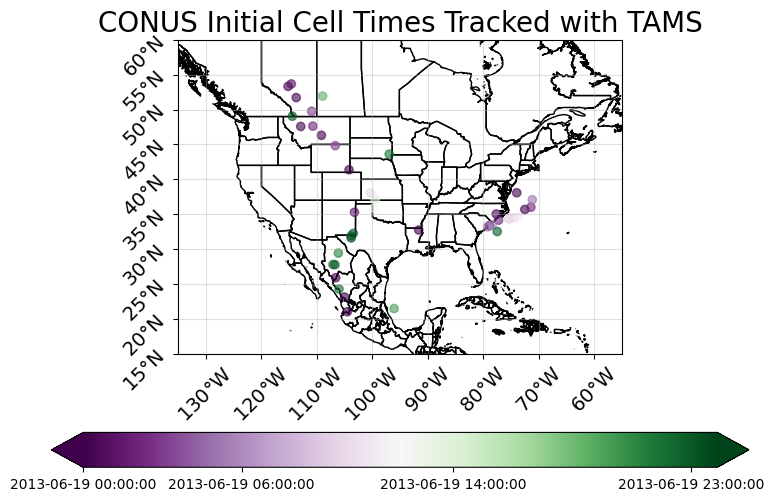

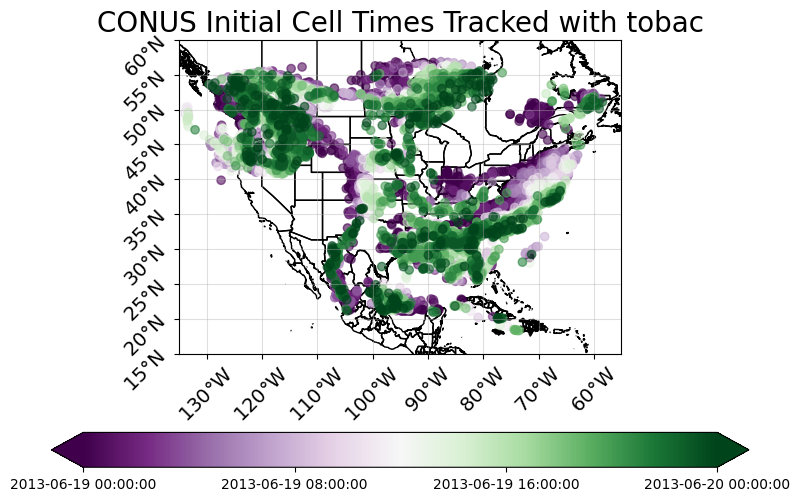

In [74]:
## PLOT INITIAL LIFETIMES

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import datetime

def plot_cell_initial_times(tracks : pd.DataFrame, 
                            dataset_name : str, 
                            tracker_name : str, 
                            specify_bounds : list[tuple, tuple] | None = None):

    # Group the cells
    cell_groups = tracks.groupby("cell_id")
    initial_time_dict = {"cell_id" : [], "datetime_time" : [], "lat" : [], "lon" : [], "frame" : []}

    # Iterate through each cell group
    for cell_id, cellg in cell_groups:
        
        # Get the information from the first row of the cell group
        start_row = cellg.iloc[0]
        start_frame = start_row["frame"]
        lat = start_row["latitude"]
        lon = start_row["longitude"]
        datetime_time = start_row["time"]

        # If the normalized lifetime is not 0, then this is not the cells initial time
        if start_row["lifetime"] != 0:
            if np.isnan(start_row["lifetime"]):
                continue
            else:
                raise ValueError("This is not the cells initial time")

        # Append all the information to the dictionary
        initial_time_dict["cell_id"].append(cell_id)
        initial_time_dict["frame"].append(start_frame)
        initial_time_dict["lat"].append(lat)
        initial_time_dict["lon"].append(lon)
        initial_time_dict["datetime_time"].append(datetime_time)

    # Make a geodataframe with all of the initial cell times
    crs = "EPSG:4326"
    geometry = gpd.points_from_xy(initial_time_dict["lon"], initial_time_dict["lat"])
    init_time_df = gpd.GeoDataFrame(initial_time_dict, crs = crs, geometry=geometry)

    # Plot the world map
    fig = plt.figure(figsize=[15, 6])
    ax = fig.add_subplot()
    url = "/share/D3/data/hweiner/ne_10m_admin_1_states_provinces.zip"
    world = gpd.read_file(url)
    world.plot(ax=ax, edgecolor='black', facecolor='none')

    # If there are no bounds specified set them
    if specify_bounds is not None:
        ax.set_xlim(*specify_bounds[0])
        ax.set_ylim(*specify_bounds[1])
    else:
        minx = np.min(init_time_df['geometry'].bounds['minx'])
        miny = np.min(init_time_df['geometry'].bounds['miny'])
        maxx = np.max(init_time_df['geometry'].bounds['maxx'])
        maxy = np.max(init_time_df['geometry'].bounds['maxy'])

        ax.set_xlim(minx * 1.005, maxx * 0.995)
        ax.set_ylim(miny * 0.995, maxy * 1.005)

    # Get the cell initial times as strings
    if type(init_time_df["datetime_time"][0]) == str:
        labels = np.unique([datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in init_time_df["datetime_time"]])
    else:
        labels = np.unique([datetime.datetime.strftime(i, "%Y-%m-%d %H:%M:%S") for i in init_time_df["datetime_time"]])

    legend_tick_spacer = int(np.floor(len(labels) / 3))

    # Plot the initial time dataframe
    init_time_df.plot(ax=ax, column="frame", legend=True, cmap="PRGn", marker='o', alpha=0.6,
                    legend_kwds={"format": mticker.FixedFormatter(labels[::legend_tick_spacer]), "orientation": "horizontal", 
                                "shrink": 0.6, "pad": 0.17, "extend": "both", "ticks" : np.unique(init_time_df["frame"])[::legend_tick_spacer]})
    
    # Set the x and y axis labels and title
    xtl = ax.get_xticklabels()
    ytl = ax.get_yticklabels()
    new_xtl = []
    new_ytl = []
    for ctl_x, ctl_y in zip(xtl, ytl):
        tx = ctl_x.get_text()
        new_xtl.append(fr'{tx[1:]}$\degree$W')
        ty = ctl_y.get_text()
        new_ytl.append(fr'{ty}$\degree$N')

    ax.set_xticklabels(new_xtl, rotation=45, fontsize=14)
    ax.set_yticklabels(new_ytl, rotation=45, fontsize=14)

    if tracker_name is not None:
        ax.set_title(f"{dataset_name} Initial Cell Times Tracked with {tracker_name}", fontsize=20)
    if tracker_name is None:
        ax.set_title(f"{dataset_name} Initial Cell Times", fontsize=20)

    plt.grid(alpha=0.4)
    plt.show()


bounds = [(-135, -55), (15, 60)]
plot_cell_initial_times(WRF_tracks_tams, dataset_name="CONUS", tracker_name="TAMS", specify_bounds=bounds)
plot_cell_initial_times(WRF_tracks_tobac, dataset_name="CONUS", tracker_name="tobac", specify_bounds=bounds)
